# Streaming

In this page the approaches ot iterate over different phases of the graph execution are considered.

In [2]:
from typing import TypedDict, Literal, Annotated

import langgraph
from langgraph.graph import StateGraph, START, END

## State streaming

You can stream the state of the graph by using the `stream` method and it's async version ,`astream`e, instead of the `invoke` method. This will return an interator that will return either the current state of the graph or it's updates, depending on the stream mode:

- The `stream_mode="updates"` (default) returns only updates of the graph.
- The `stream_mode="values"` returns entire state at each step.

---

Consider an example in which a graph adds random values to a list until it reaches a specified length.

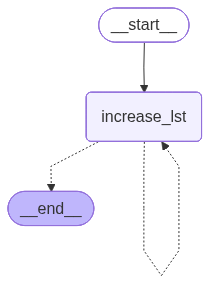

In [3]:
import random
import operator


class State(TypedDict):
    lst: Annotated[list[str], operator.add]


def increase_lst(
    state: State
) -> langgraph.types.Command[Literal["increase_lst", END]]:
    if len(state["lst"]) < 3:
        return langgraph.types.Command(
            update={"lst": [random.choice([
                "hello", "world", "this", "is", "me"
            ])]},
            goto="increase_lst"
        )
    return langgraph.types.Command(goto=END)


graph = (
    StateGraph(State)
    .add_node("increase_lst", increase_lst)
    .add_edge(START, "increase_lst")
    .compile()
)

graph

Invoking of the graph works just as expected: the output contains a list with the specified number of elements.

In [4]:
graph.invoke(State(lst=[]))

{'lst': ['me', 'me', 'world']}

If the `stream` method is invoked, an iterator is created:

In [5]:
next(iter(graph.stream(State(lst=[]))))

{'increase_lst': {'lst': ['is']}}

The following cell iterates through all the outputs of the graph:

In [6]:
for s in graph.stream(State(lst=[])):
    print(s["increase_lst"])

{'lst': ['world']}
{'lst': ['this']}
{'lst': ['me']}
None


Next code shows the `stream_mode="values"` case:

In [7]:
for s in graph.stream(State(lst=[]), stream_mode="values"):
    print(s)

{'lst': []}
{'lst': ['hello']}
{'lst': ['hello', 'hello']}
{'lst': ['hello', 'hello', 'world']}


We get all the corresponding states at each step.

## Events streaming

Using the grpaph's `astream_events` method, you can execute graph events as langgraph accesses them.

---

The following cell creates a simple graph and shows some attributes of the events returned from the corresponding iterator.

In [8]:
class State(TypedDict):
    pass


def node(state: State):
    pass


graph = (
    StateGraph(State)
    .add_node("node", node)
    .add_edge(START, "node")
    .add_edge("node", END)
    .compile()
)

async for event in graph.astream_events(State()):
    print(event["event"], event["name"])

on_chain_start LangGraph
on_chain_start node
on_chain_stream node
on_chain_end node
on_chain_stream LangGraph
on_chain_end LangGraph


### Model stream

One of the most useful events is `on_chat_model_stream`. This event type retains the tokens returned by the call to the model - each token represents a different Langgraph event.

---

The following cell creates a graph which only node invokes the model with the given message.

In [9]:
from langchain_ollama import ChatOllama


class State(TypedDict):
    question: str


model = ChatOllama(
    model="llama3.1"
)


def node(state: State):
    model.invoke(state["question"])


graph = (
    StateGraph(State)
    .add_node("node", node)
    .add_edge(START, "node")
    .add_edge("node", END)
    .compile()
)

The following cell iterates over `on_chat_model_stream` events, and shows the content of the messages.

In [10]:
input_state = State(question="What is the capital of France")
async for event in graph.astream_events(input_state):
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content)

The
 capital
 of
 France
 is
 Paris
.


